# Introduction to Sparsity III: Deconvolution

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018  
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---

## Contents

1. [Set-Up](#Set-Up)

---

## Set-Up

Here we will import a couple of packages that we be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np

from scipy.ndimage import gaussian_filter

# Import function to set size of figures.
from matplotlib.pylab import rcParams

# Import interaction module.
from ipywidgets.widgets import *

# Import tutorial functions.
from sparsity_tutorial import plot
from sparsity_tutorial.functions import *

In [2]:
# Set size of figures.
rcParams['figure.figsize'] = (14.0, 8.0)

# normalised FFT
def fft(data):
    
    return 1 / np.sqrt(data.size) * np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data)))

# normalised inverse FFT
def ifft(data):

    return np.sqrt(data.size) * np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data)))

# Function for performing soft thresholding with complex coefficients.
def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold / np.maximum(np.finfo(np.float64).eps, np.abs(data))),0.0) * data, 
                     decimals=15)

# Function to measure the l1 norm.
def l1_norm(signal):

    return np.sum(np.abs(signal))

In [3]:
x = np.load('data/cs_true_data.npy').reshape(100, 100)

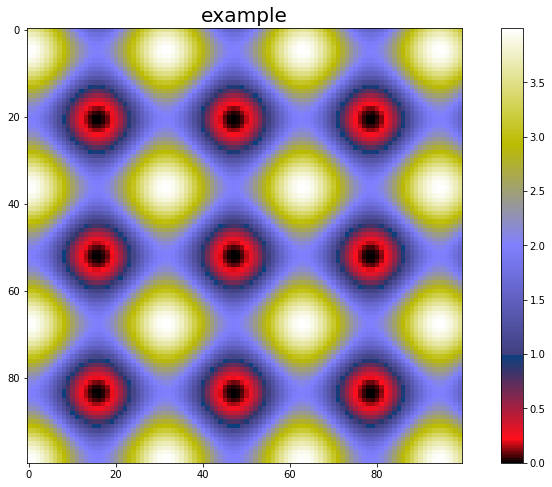

In [4]:
plot.display(x)

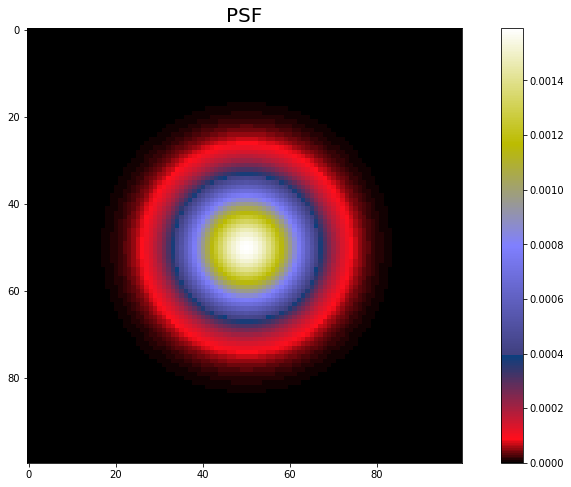

In [5]:
# Generate a Gaussian PSF.
psf = np.zeros(x.shape)
psf[list(zip(np.array(psf.shape) // 2))] = 1
psf = gaussian_filter(psf, 10)

plot.display(psf, title='PSF')

In [6]:
# This function convolves an image with a kernel using FFT.
def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

# This function deconvolves an image with a kernel using FFT.
def fftdeconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x / y))))

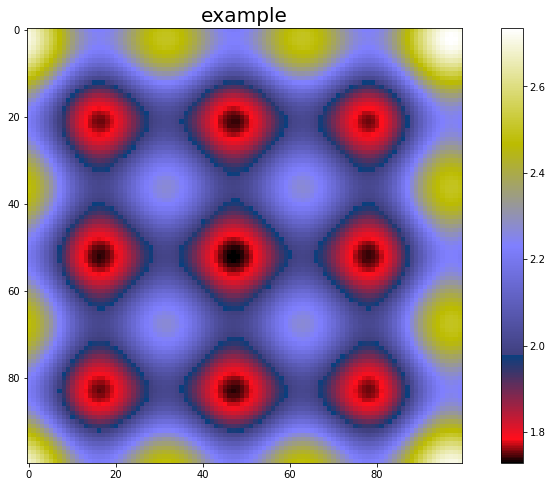

In [7]:
y = fftconvolve(x, psf)

plot.display(y)

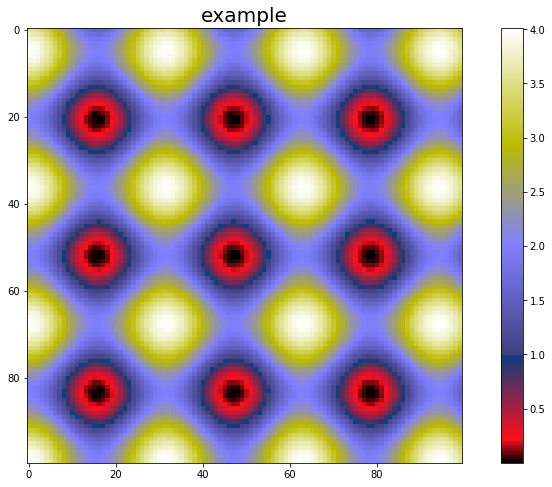

In [8]:
z = fftdeconvolve(y, psf)

plot.display(z)

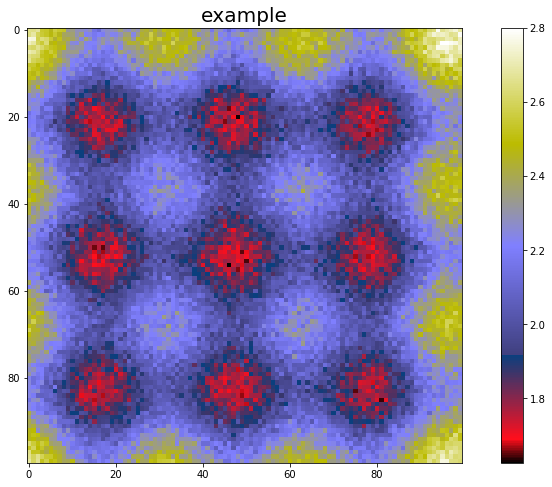

In [9]:
y = fftconvolve(x, psf) + 0.05 * np.random.randn(*x.shape)

plot.display(y)

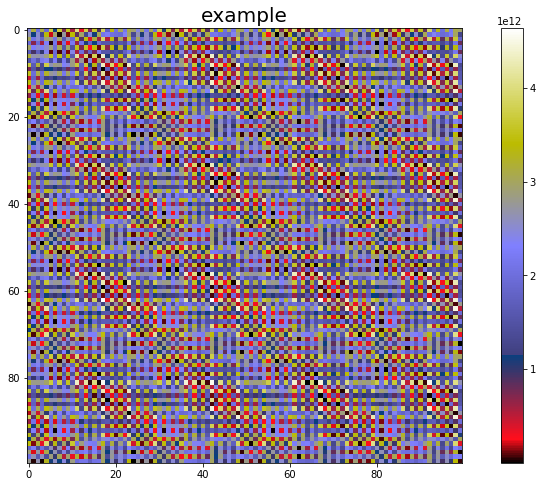

In [10]:
z = fftdeconvolve(y, psf)

plot.display(z)

In [11]:
def H(data, psf):
    
    return fftconvolve(data, psf)

def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))

In [12]:
def grad(y, alpha_rec, psf):
    
    return ifft(Ht(H(fft(alpha_rec), psf) - y, psf))

In [13]:
# Function to calculate the cost.
def cost_func(y, alpha_rec, psf, lambda_):
    
    return (0.5 * np.linalg.norm(y - H(fft(alpha_rec), psf)) ** 2 + lambda_ * l1_norm(alpha_rec))


# Function that performs simple forward backward splitting.
def forwardBackward(observation, first_guess, psf, grad, lambda_, n_iter=300, gamma=1.0, return_cost=False):
    
    alpha_rec = first_guess
    cost = []
            
    for i in range(n_iter):
        
        alpha_temp = alpha_rec - gamma * grad(observation, alpha_rec, psf)
        alpha_rec = soft_thresh(alpha_temp, lambda_)
        cost.append(cost_func(observation, alpha_rec, psf, lambda_))
    
    if return_cost:
        return alpha_rec, cost
    else:
        return alpha_rec

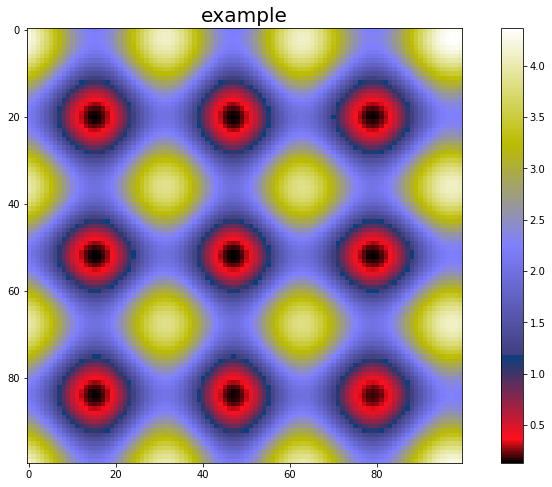

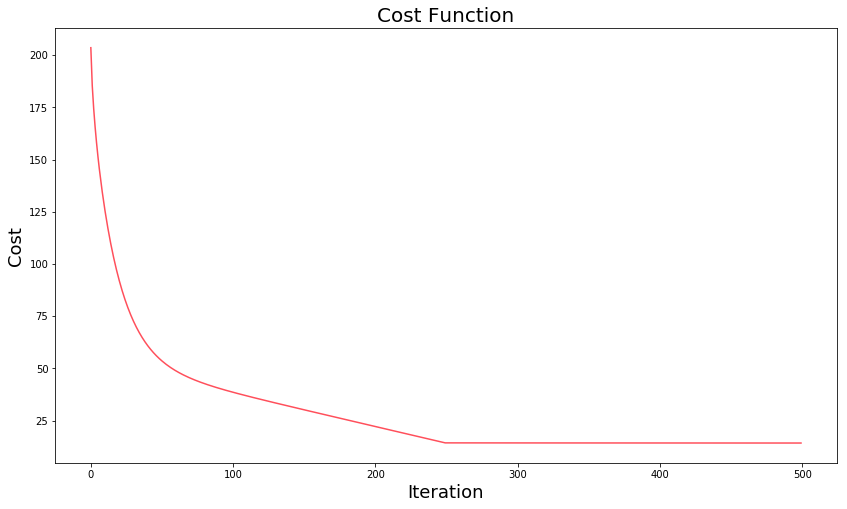

In [14]:
alpha_rec, cost = forwardBackward(y, np.ones(x.shape), psf, grad, lambda_=0.004, n_iter=500, return_cost=True)

plot.display(fft(alpha_rec))
plot.cost_plot(cost)